# What will we do in this project?

### In this project we will take a look at the survival rate of patients with advanced lung cancer.

Survival Analysis is very common for subscribing types of businesses and can help avoid customer churn.

Let's imagine that a customer decides to cancel his subscription. Survivasl analysis helps us answer the question 'How long should I wait before trying to get the customer back?'

In [38]:
# Import library
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

In [3]:
# Import the data
df = pd.read_csv('lung.csv')

In [4]:
df.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


## How to read the data?

- **inst**: Institution code
- **time**: Survival time in days
- **status**: censoring status 1=censored, 2=dead
- **age**: Age in years
- **sex**: Male=1 Female=2
- **ph.ecog**: ECOG performance score as rated by the physician. 0=asymptomatic, 1= symptomatic but completely ambulatory, 2= in bed <50% of the day, 3= in bed > 50% of the day but not bedbound, 4 = bedbound
- **ph.karno**: Karnofsky performance score (bad=0-good=100) rated by physician
- **pat.karno**: Karnofsky performance score as rated by patient
- **meal.cal**: Calories consumed at meals
- **wt.loss**: Weight loss in last six months

In [9]:
# data transformation
df.loc[df['status'] == 1, 'status'] = 0
df.loc[df['status'] == 2, 'status'] = 1

In [10]:
df.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0


The probability of me surviving today depends on the probability of me surviving yesterday and the probability of me surviving today can never be greater than the probability of me surviving yesterday

## Kaplan–Meier estimator

A non-parametric statistic used to estimate the survival function from lifetime data.

Fomula: $$S(t_{i}) = S(t_{i-1}) * (1 - \frac{d_{i}}{n_{i}})$$ 

### How to read this formula?

The probability of surviving at time t depends on the probability of surviving at t-1 ie the probability of surviving the day before, multiplied by the probability of surviving at time t. The result of 

$$(1 - \frac{d_{i}}{n_{i}})$$ 

is always less than 1 and therefore the probability of survival will always be lower than that of the previous day.

## We can start to train and fit our model.

In [15]:
model = KaplanMeierFitter()
model.fit(durations=df['time'], event_observed=df['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 228 total observations, 63 right-censored observations>

### Censoring
One aspect that makes survival analysis difficult is the concept of censoring. What this means is that when a subject under obsevation is censored we don’t know the true survival time. 

**Right-censoring**:
Right-censoring, the most common type of censoring it happens when the subject under observation is still alive.

**Left-censoting**:
In contrast to right-censoring, left censoring occurs when the person’s true survival time is less than or equal to the observed survival time. 

**Interval-censoring**:
Interval-censoring occurs in survival analysis when the time until an event of interest is not known precisely (and instead, only is known to fall into a particular interval).

In [16]:
model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223
...,...,...,...,...,...
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3


### Now that we have our model we can calculate the probability of survival for a specific event (day).

In [18]:
# calculating for specific event (day 5)
day_5 = model.event_table.iloc[1, :]
print(day_5)

removed       1
observed      1
censored      0
entrance      0
at_risk     228
Name: 5.0, dtype: int32


**We ha 228 subject at risk and 1 subject was removed because he did not survive.**

In [21]:
# calculating the probability of the subject to survive 
surv_5 = 1 * (1- day_5.observed/day_5.at_risk)
surv_5

0.9956140350877193

In [22]:
# calculating for specific event (day 11)
day_11 = model.event_table.iloc[2, :]
print(day_11)

removed       3
observed      3
censored      0
entrance      0
at_risk     227
Name: 11.0, dtype: int32


**We ha 227 subject at risk and 3 subjects were removed because he did not survive.**

In [23]:
# calculating the probability of the subject to survive 
surv_11 = surv_5 * (1- day_11.observed/day_11.at_risk)
surv_11

0.9824561403508771

Obviously doing it this way would be very time consuming for the more distant events, but we can calculate an approximation:

In [24]:
# Approximation
surv_11_approximate = (day_11.at_risk - day_11.observed)/day_11.at_risk
surv_11_approximate

0.986784140969163

## Ploting the survival curve

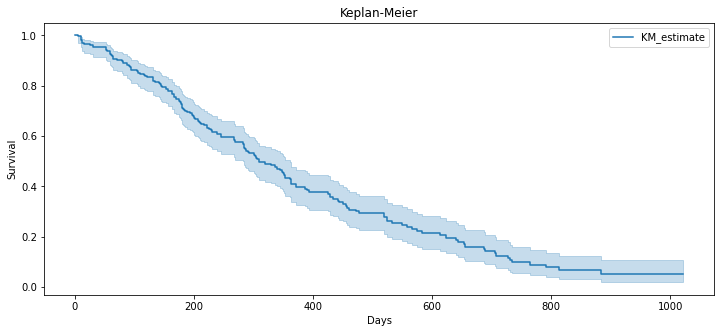

In [28]:
model.plot(figsize=(12,5))
plt.title('Keplan-Meier')
plt.xlabel('Days')
plt.ylabel('Survival')
plt.show()

## Ploting the survival cumulative curve


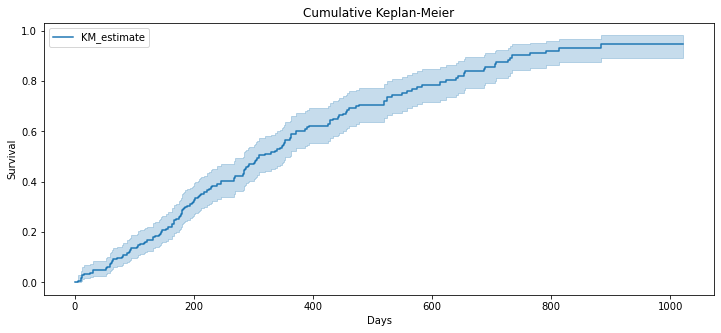

In [29]:
model.plot_cumulative_density(figsize=(12,5))
plt.title('Cumulative Keplan-Meier')
plt.xlabel('Days')
plt.ylabel('Survival')
plt.show()

# Is there a difference between females and males?

To answer this question we can use the **Log Rank Test**

In [30]:
# creting two DataFrame

male = df.query('sex == 1')
female = df.query('sex == 2')

In [31]:
# Kaplan-Meier per gender
model_males = KaplanMeierFitter()
model_males.fit(durations=male['time'], event_observed=male['status'])

model_females = KaplanMeierFitter()
model_females.fit(durations=female['time'], event_observed=female['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 90 total observations, 37 right-censored observations>

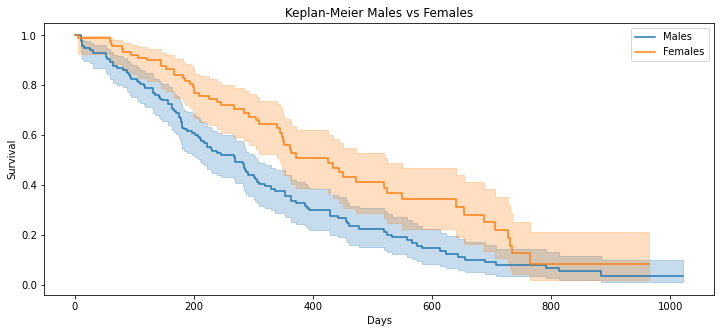

In [36]:
model_males.plot(figsize=(12,5), label='Males')
model_females.plot(label='Females')
plt.title('Keplan-Meier Males vs Females')
plt.xlabel('Days')
plt.ylabel('Survival')
plt.show()

In [40]:
# Log Rank Test
results  = logrank_test(durations_A=male['time'], durations_B=female['time'], event_observed_A=male['status'], event_observed_B=female['status'])

In [41]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

In [43]:
alpha = 0.05
pvalue= results.p_value
if pvalue > alpha:
    print('Failed to reject null H. There is no difference between the group')
else:
    print('Rejected null H. The groups are different')

Rejected null H. The groups are different


**The log-rank test allowed us to answer the question: there is a difference in the probability of survival between men and women, with women showing a higher probability and this difference is statistically significant.**